In [1]:
%reset -f

In [2]:
import torch
import torch.nn as nn
import numpy as np
import scipy.io as reader
from matplotlib import pyplot as plt 
import utils

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
class Net(nn.Module):
    def __init__(self, layers):
        super(Net, self).__init__()
        self.layers = layers
        self.iter = 0
        self.activation = nn.Tanh()
        self.linear = nn.ModuleList([nn.Linear(layers[i], layers[i + 1]) for i in range(len(layers) - 1)])
        for i in range(len(layers) - 1):
            nn.init.xavier_normal_(self.linear[i].weight.data, gain=1.0)
            nn.init.zeros_(self.linear[i].bias.data)

    def forward(self, x):
        if not torch.is_tensor(x):
            x = torch.from_numpy(x)
        a = self.activation(self.linear[0](x))
        for i in range(1, len(self.layers) - 2):
            z = self.linear[i](a)
            a = self.activation(z)
        a = self.linear[-1](a)
        return a

In [4]:
data = reader.loadmat('./burgers_shock.mat')

x = data['x'].flatten()[:, None]
t = data['t'].flatten()[:, None]
Exact = np.real(data['usol'])

X, T = np.meshgrid(x, t)
X, T = X.T, T.T


x_test_np = np.concatenate((np.vstack(np.expand_dims(T, axis=2)), np.vstack(np.expand_dims(X, axis=2))), axis=-1)
x_test = torch.from_numpy(x_test_np).float().to(device)

In [5]:
net = Net([2, 20, 20, 20, 20, 1]).to(device)
net.load_state_dict(torch.load('./best_model2bgs.pth'))

<All keys matched successfully>

In [6]:
from pyDOE import lhs
lb = np.array([0.0, -1.0])
ub = np.array([1.0, 1.0])
def random_fun(num):
    temp = torch.from_numpy(lb + (ub - lb) * lhs(2, num)).float().to(device)
    return temp

In [7]:
imgl = net(x_test).reshape([256,100]).to(device)

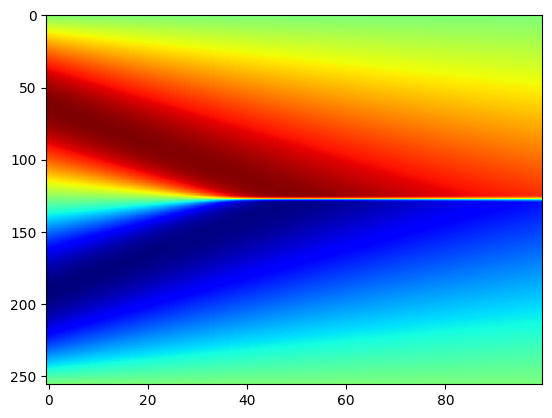

In [8]:
plt.imshow(imgl.cpu().detach().numpy(), aspect='auto', cmap='jet')

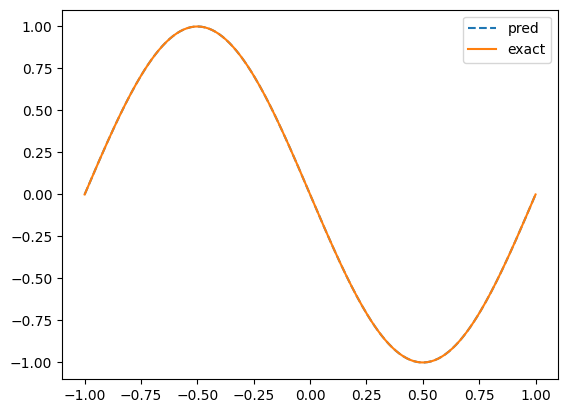

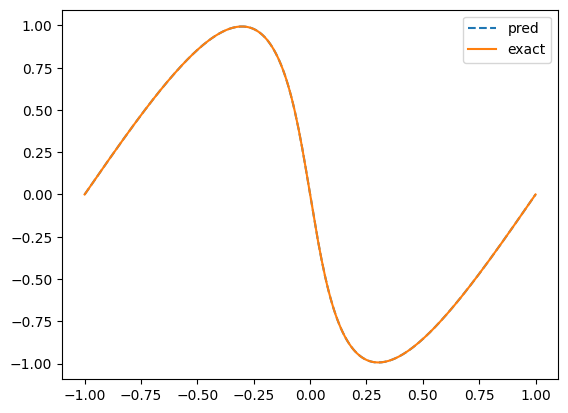

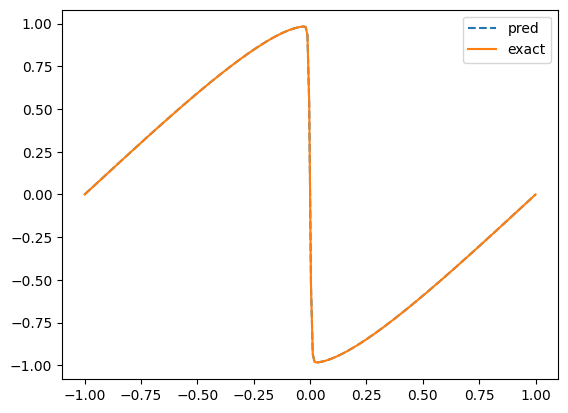

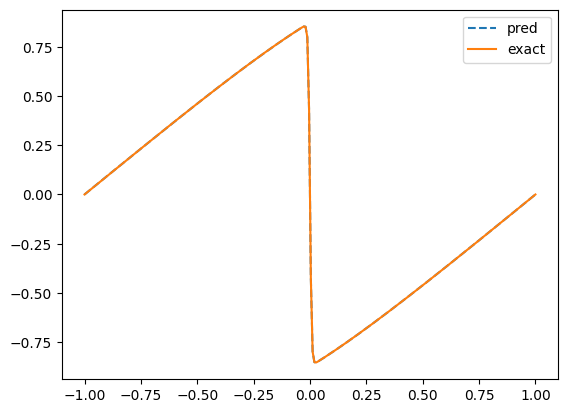

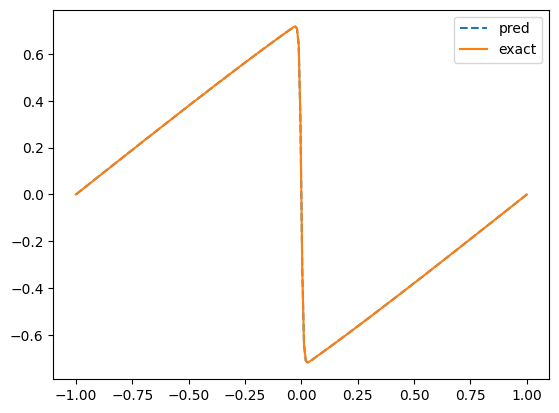

In [9]:
x_test_pred = imgl.cpu().detach().numpy()
x_test_pred = x_test_pred.reshape(x.shape[0], t.shape[0])
# x_test_pred = x_test_pred.to('cpu').detach().numpy()
x_test_exact = Exact
# x_test_exact = x_test_exact.to('cpu').detach().numpy()
# x = x.to('cpu').detach().numpy()
# t = t.to('cpu').detach().numpy()
plt.figure()
plt.plot(x, x_test_pred[:, 0], label='pred', linestyle='--')
plt.plot(x, x_test_exact[:, 0], label='exact')
plt.legend()
plt.figure()
plt.plot(x, x_test_pred[:, 20], label='pred', linestyle='--')
plt.plot(x, x_test_exact[:, 20], label='exact')
plt.legend()
plt.figure()
plt.plot(x, x_test_pred[:, 50], label='pred', linestyle='--')
plt.plot(x, x_test_exact[:, 50], label='exact')
plt.legend()
plt.figure()
plt.plot(x, x_test_pred[:, 75], label='pred', linestyle='--')
plt.plot(x, x_test_exact[:, 75], label='exact')
plt.legend()
plt.figure()
plt.plot(x, x_test_pred[:, 99], label='pred', linestyle='--')
plt.plot(x, x_test_exact[:, 99], label='exact')
plt.legend()

In [16]:
j0 = 0
J = 5
e = 0.03

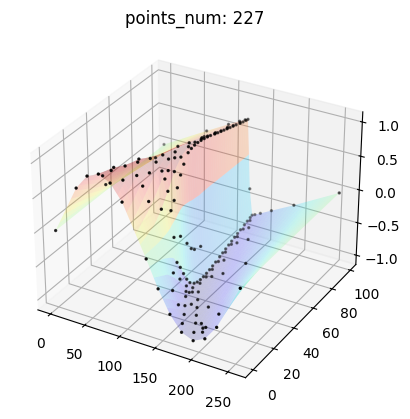

<Figure size 640x480 with 0 Axes>

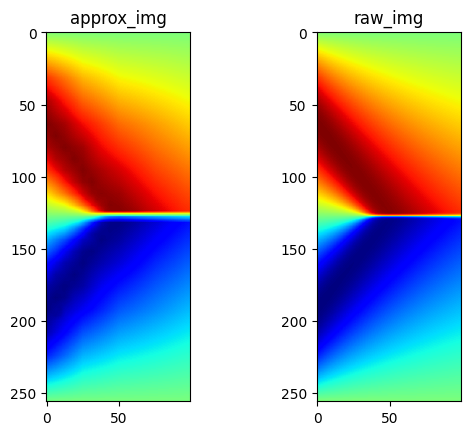

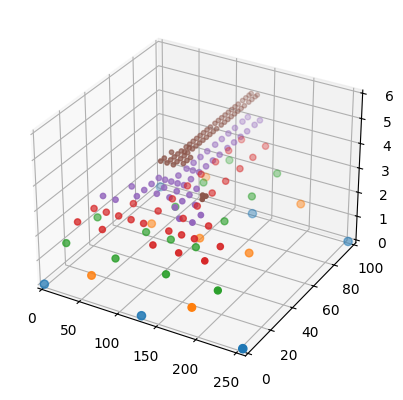

In [17]:
xc1 = torch.arange(lb[1], ub[1], 2/imgl.shape[0]).reshape((-1,1)).to(device)
xr1 = torch.arange(lb[0], ub[0], 1/imgl.shape[1]).reshape((-1,1)).to(device)
iwtmodel = utils.torchIWT(j0, J, e)
iwtmodel = iwtmodel.to(device)
approx, indicies = iwtmodel.get_Iwt2d(imgl, xc1, xr1)
l=-1
utils.show_approx(imgl.cpu().detach().numpy(), approx.cpu().detach().numpy(), indicies, level_points=l, s=1, cmap='jet', show_2d_points=False, al=0.2)
utils.show_3d_points(approx.cpu().detach().numpy(), indicies, level_points=l)

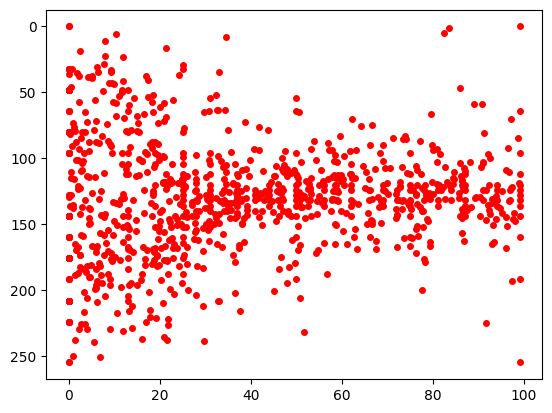

In [25]:
# scatter indicies
idxn = []
for i in indicies:
    idxn = idxn + i
idxn = torch.tensor(idxn).to(device).float()

from scipy.stats import gaussian_kde
kde = gaussian_kde(idxn.cpu().T)
expanded_idxns = kde.resample(1000).T
expanded_idxns = torch.tensor(expanded_idxns).float().to(device)
k = torch.cat((idxn, expanded_idxns), dim=0)
k = k[(k[:, 0] >= 0) & (k[:, 0] <= 255) & (k[:, 1] >= 0) & (k[:, 1] <= 99)]

plt.figure()
plt.plot(k[:, [1]].cpu().numpy(), k[:, [0]].cpu().numpy(), 'ro', markersize=4)
plt.gca().invert_yaxis()


In [19]:
err = np.linalg.norm(imgl.cpu().detach().numpy() - Exact, 2) / np.linalg.norm(Exact, 2)
print('Relative L2 error: {:.4e}'.format(err))

Relative L2 error: 1.2052e-04


Text(0.5, 1.0, 'L2 error: 1.2052e-04')

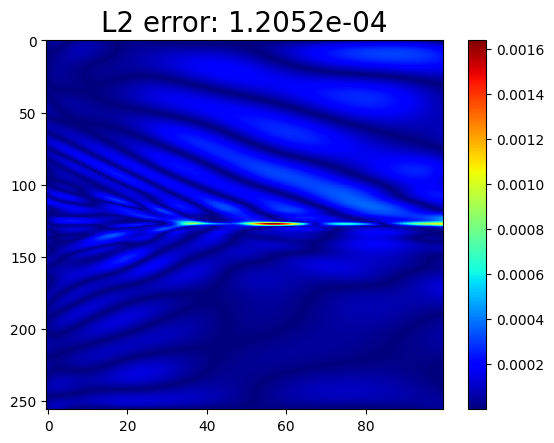

In [20]:
plt.figure()
plt.imshow(np.abs(imgl.cpu().detach().numpy() - Exact), aspect='auto', cmap='jet')
plt.colorbar()
plt.title('L2 error: {:.4e}'.format(err), fontsize=20)

C:\Users\www\AppData\Local\Temp\ipykernel_17112\2674848229.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_init = torch.tensor(x_init, requires_grad=True).float().to(device)


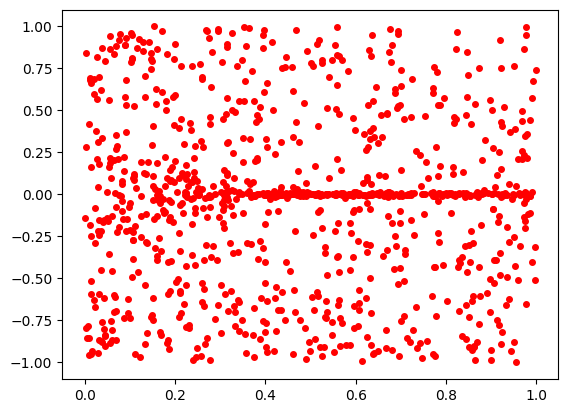

In [21]:
x_init = random_fun(100000)
x_init = torch.tensor(x_init, requires_grad=True).float().to(device)
u =net(x_init)
x_init.requires_grad = True
dx = torch.autograd.grad(u, x_init, grad_outputs=torch.ones_like(u), create_graph=True,allow_unused=True)[0]
grad_x1 = dx[:, [0]].squeeze()
grad_x2 = dx[:, [1]].squeeze()
dx = torch.sqrt(1 + grad_x1 ** 2 + grad_x2 ** 2).cpu().detach().numpy()
err_dx = np.power(dx, 1) / np.power(dx, 1).mean()
p = (err_dx / sum(err_dx))
X_ids = np.random.choice(a=len(x_init), size=1000, replace=False, p=p)
x_f_M = x_init[X_ids]
# plt x_f_M
plt.figure()
plt.plot(x_f_M.cpu().detach().numpy()[:, 0], x_f_M.cpu().detach().numpy()[:, 1], 'ro', markersize=4)